# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. We will build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Loading libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/datasets/taxi.csv')


In [3]:
df.head()


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Checking null values
df.isna().sum()


datetime      0
num_orders    0
dtype: int64

In [6]:
# Checking duplicates
df.duplicated().sum()


0

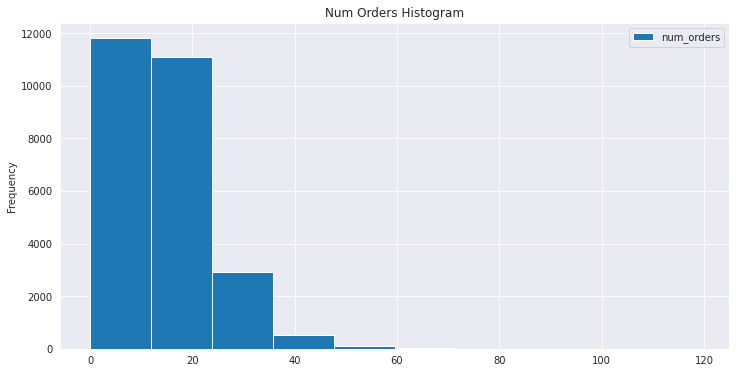

In [7]:
# Checking distribution of data
df.plot(kind='hist')
plt.title('Num Orders Histogram')
plt.show()


* We can see a right skewed distribution on the histogram.

In [8]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [9]:
df.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
df.index.is_monotonic


True

### Conclusion

* Data contains 26496 rows and 2 columns which are datetime and num_orders.
* Date column data type should be datetime data type.
* No missing values
* Data has right skewed distribution.
* Parsed the date data type into datetime.


## Analysis

Resampling by 1 hour, 1 week and 1 month.

In [11]:
df_monthly = df.resample('1M').sum()
df_weekly = df.resample('1W').sum()
df_hourly = df.resample('1H').sum()


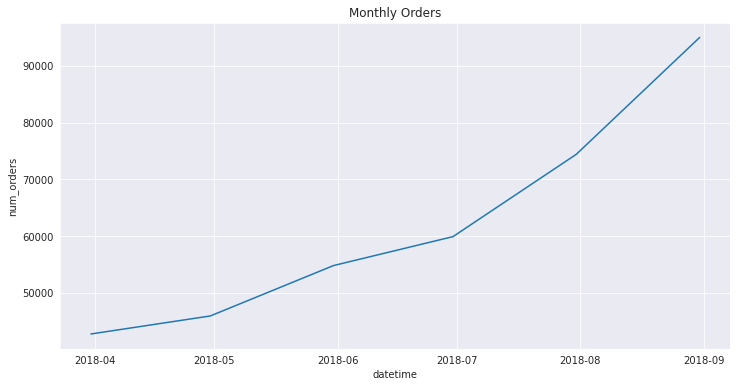

In [12]:
# Plotting monthly orders
sns.lineplot(x=df_monthly.index,y=df_monthly['num_orders'])
plt.title('Monthly Orders')
plt.show()


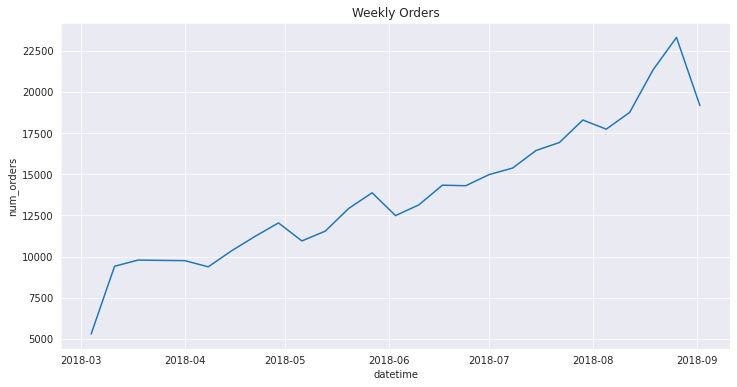

In [13]:
# Plotting weekly orders
sns.lineplot(x=df_weekly.index,y=df_weekly['num_orders'])
plt.title('Weekly Orders')
plt.show()


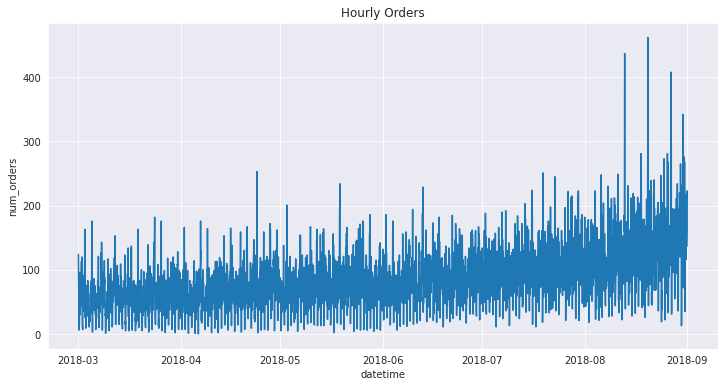

In [14]:
# Plotting hourly orders
sns.lineplot(x=df_hourly.index,y=df_hourly['num_orders'])
plt.title('Hourly Orders')
plt.show()


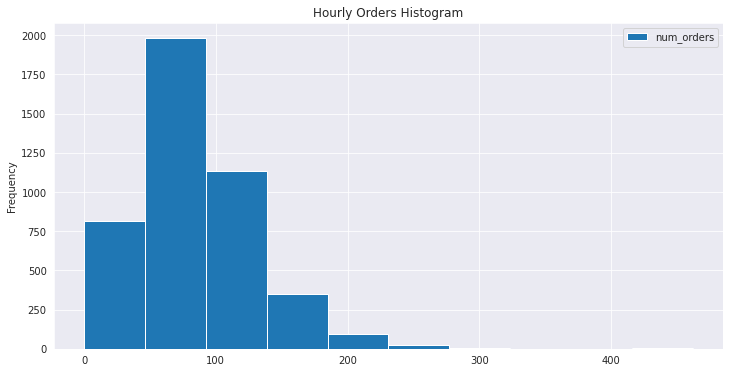

In [15]:
# Hourly Histogram
df_hourly.plot(kind='hist')
plt.title('Hourly Orders Histogram')
plt.show()


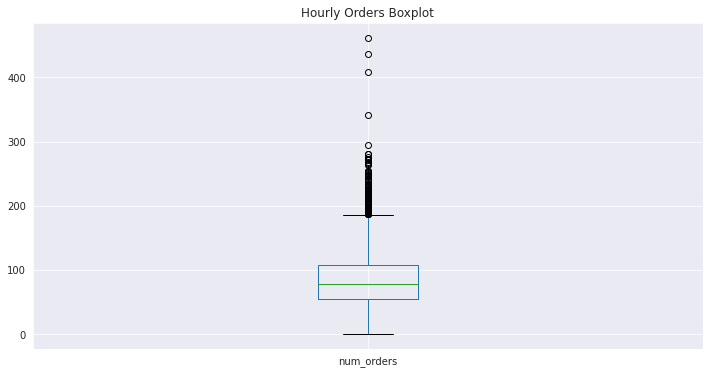

In [16]:
# Boxplot hourly
df_hourly.boxplot()
plt.title('Hourly Orders Boxplot')
plt.show()


In [17]:
df_hourly.describe()


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

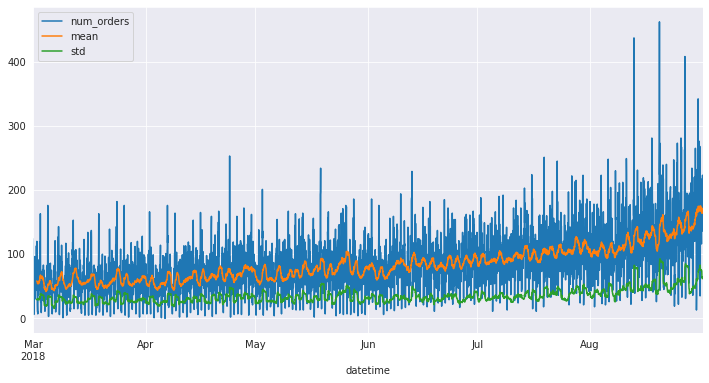

In [18]:

df_hourly['mean'] = df_hourly['num_orders'].rolling(25).mean()
df_hourly['std'] = df_hourly['num_orders'].rolling(25).std()
df_hourly.plot()


The moving average and moving standard deviation.

### Conclusion

* From the chart, the number of orders is gradually increasing each month.

## Training

In [19]:
# Resampling 1 hour
df = df.resample('1H').sum()


In [20]:
# Creating features
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)


In [21]:
df.describe()


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4407.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.320198
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,30.263125
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.888889
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.555556
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.888889
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.111111
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,223.111111


In [22]:
# Splitting data into train, test samples and using test set for best model
train, test = train_test_split(df, shuffle=False, test_size=0.5)
train = train.dropna()


In [23]:
# Splitting training data to test on all models
train_1, samp_test = train_test_split(train, shuffle=False, test_size=0.5)
train_1 = train_1.dropna()


In [24]:
# To all test models
X_train1 = train_1.drop(['num_orders'], axis=1)
y_train1 = train_1['num_orders']
X_test1 = samp_test.drop(['num_orders'],axis=1)
y_test1 = samp_test['num_orders']

In [25]:
# For best model later
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']


In [26]:
train_1.head()


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.666667
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,44.555556
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.222222
2018-03-01 12:00:00,30,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,45.000000
2018-03-01 13:00:00,32,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,41.000000


In [27]:
samp_test.head()


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-04-16 04:00:00,37,0,4,77.0,79.0,109.0,165.0,119.0,104.0,94.0,66.0,97.0,101.111111
2018-04-16 05:00:00,31,0,5,37.0,77.0,79.0,109.0,165.0,119.0,104.0,94.0,66.0,94.444444
2018-04-16 06:00:00,13,0,6,31.0,37.0,77.0,79.0,109.0,165.0,119.0,104.0,94.0,90.555556
2018-04-16 07:00:00,22,0,7,13.0,31.0,37.0,77.0,79.0,109.0,165.0,119.0,104.0,81.555556
2018-04-16 08:00:00,69,0,8,22.0,13.0,31.0,37.0,77.0,79.0,109.0,165.0,119.0,72.444444


In [28]:
print('Training sample size:', X_train1.shape)
print('Test sample size:', X_test1.shape)


Training sample size: (1099, 12)
Test sample size: (1100, 12)


# Linear Regression

In [29]:
%%time
lr = LinearRegression()
lr.fit(X_train1,y_train1)
lr_predictions = lr.predict(X_test1)
print('RMSE:', mean_squared_error(y_test1, lr_predictions)**0.5)


RMSE: 30.44817213508371
CPU times: user 3.95 ms, sys: 4.35 ms, total: 8.3 ms
Wall time: 3.66 ms


# Decision Tree Regressor

In [30]:
%%time
dtr = DecisionTreeRegressor(random_state=12345)
dtr.fit(X_train1,y_train1)
dtr_predictions = dtr.predict(X_test1)
print('RMSE:', mean_squared_error(y_test1, dtr_predictions)**0.5)


RMSE: 33.74406345095117
CPU times: user 12.6 ms, sys: 33.6 ms, total: 46.2 ms
Wall time: 61 ms


# Random Forest Regressor

In [31]:
%%time
rfr = RandomForestRegressor(random_state=12345)
rfr.fit(X_train1,y_train1)
rfr_predictions = rfr.predict(X_test1)
print('RMSE:', mean_squared_error(y_test1, rfr_predictions)**0.5)


RMSE: 26.929409653253213
CPU times: user 520 ms, sys: 31.8 ms, total: 552 ms
Wall time: 586 ms


# XGBoost Regressor

In [32]:
%%time
xgb = XGBRegressor()
xgb.fit(X_train1,y_train1)
xgb_predictions = xgb.predict(X_test1)
print('RMSE:', mean_squared_error(y_test1, xgb_predictions)**0.5)


RMSE: 29.141489130336222
CPU times: user 795 ms, sys: 0 ns, total: 795 ms
Wall time: 798 ms


# CatBoost Regressor

In [33]:
%%time
cbr = CatBoostRegressor(loss_function="RMSE", verbose=False,random_state=12345)
cbr.fit(X_train1,y_train1)
cbr_predictions = cbr.predict(X_test1)
print('RMSE:', mean_squared_error(y_test1, cbr_predictions)**0.5)


RMSE: 27.352224595634887
CPU times: user 1.16 s, sys: 4 ms, total: 1.16 s
Wall time: 1.3 s


# LGBM Regressor

In [34]:
%%time
lgbm = LGBMRegressor(random_state=12345)
lgbm.fit(X_train1,y_train1)
lgbm_predictions = lgbm.predict(X_test1)
print('RMSE:', mean_squared_error(y_test1, lgbm_predictions)**0.5)


RMSE: 27.8381702966086
CPU times: user 214 ms, sys: 2.01 ms, total: 216 ms
Wall time: 198 ms


The best model was LGBM Regressor, so let's do cross validation with TimeSeriesSplit

In [35]:
param_grid = {
    'n_estimators' : [50,100,200,300,350],
    'num_leaves' : [2,5,7,12]
}
lgbm_model = LGBMRegressor(random_state=12345, objective='regression')
def rmse_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5
rmse_score = make_scorer(rmse_error, greater_is_better = False)
tscv = TimeSeriesSplit(n_splits=5)
clf = GridSearchCV(estimator = lgbm, scoring=rmse_score, param_grid=param_grid, cv=tscv).fit(X_train,y_train)
best_params = clf.best_params_
print(best_params)
print(clf.best_score_)


{'n_estimators': 50, 'num_leaves': 12}
-22.517576238200217


### Conclusion

* LightGBM Regressor had the best result on the training set with RMSE=27.83 and the best time.
* TimeSeriesSplit with n_splits=5 for cross validation using GridSearchCV at LGBM regressor model to get the best parameters and best score to use them at testing.

## Testing

In [36]:
%%time
model = LGBMRegressor(**best_params)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print('RMSE on test sample:', mean_squared_error(y_test, predictions)**0.5)


RMSE on test sample: 38.44894273694273
CPU times: user 85.3 ms, sys: 3.37 ms, total: 88.7 ms
Wall time: 97.4 ms


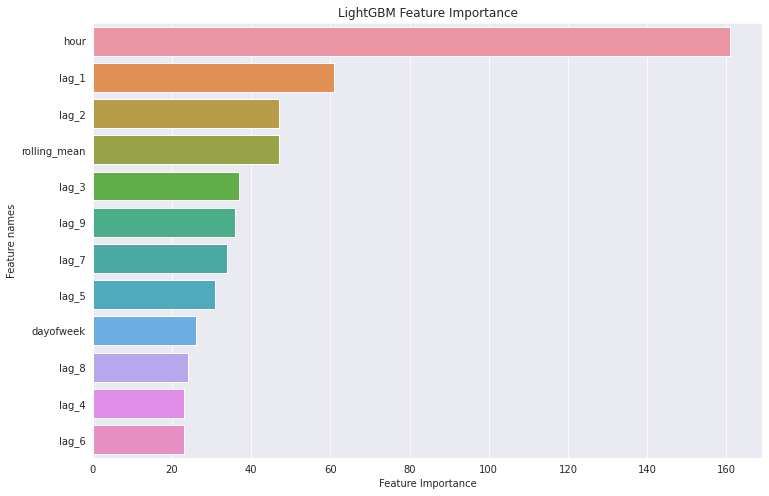

In [37]:
feature_importance = np.array(model.feature_importances_)
feature_names = np.array(X_test.columns)

# Creating a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
df_fi = pd.DataFrame(data)

# Sorting the DataFrame in order of decreasing feature importance
df_fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(12,8))
sns.barplot(x=df_fi['feature_importance'], y=df_fi['feature_names'])
plt.title('LightGBM Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature names')
plt.show()


The chart shows the real number of orders per day that was predicted by our model.

In [38]:
orders_real = y_test.copy()
orders_predictions = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_result = pd.merge(orders_real, orders_predictions, how = 'left', left_index = True, right_index = True)


In [39]:
df_result.sample(5)


,num_orders,predictions
datetime,,
2018-07-20 16:00:00,121,95.214000
2018-07-03 05:00:00,40,33.905633
2018-08-25 03:00:00,187,119.222853
2018-08-20 06:00:00,47,66.382438
2018-06-01 04:00:00,65,86.304042


In [40]:
df_result['predictions'] = df_result['predictions'].astype('int64')
df_result['predictions']


datetime
2018-06-01 00:00:00    127
2018-06-01 01:00:00     66
2018-06-01 02:00:00     90
2018-06-01 03:00:00    102
2018-06-01 04:00:00     86
                      ... 
2018-08-31 19:00:00    107
2018-08-31 20:00:00    123
2018-08-31 21:00:00    123
2018-08-31 22:00:00    126
2018-08-31 23:00:00    133
Freq: H, Name: predictions, Length: 2208, dtype: int64

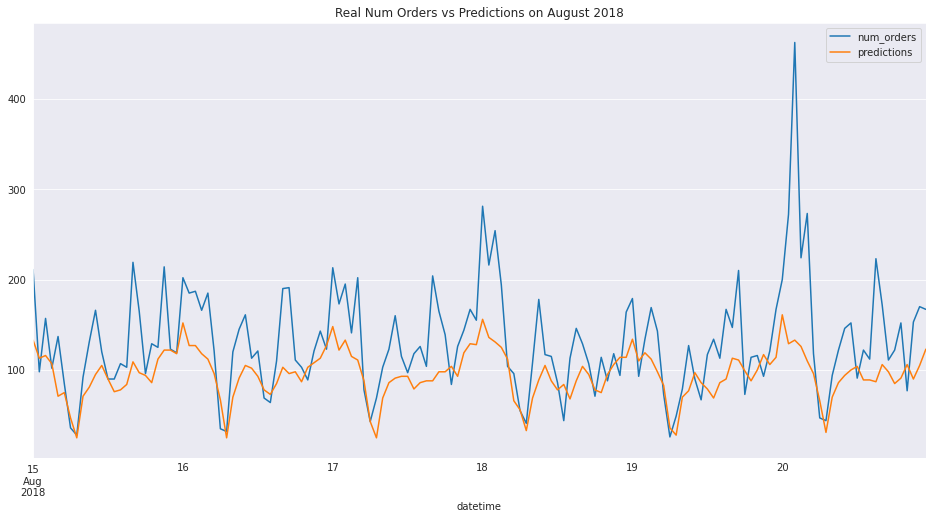

In [41]:
df_result['2018-08-15':'2018-08-20'].plot(figsize=(16,8))
plt.title('Real Num Orders vs Predictions on August 2018')
plt.show()


### Conclusion

* The model fits pretty well with the real orders
* We got the result of RMSE=38.44 on the test sample from LGBM Regressor model (using the best parameters from model training while doing TimeSeriesSplit cross validation) with fast time running result of 94ms.

# Overall Conclusion
1. Data contains 26496 rows and 2 columns which are datetime and num_orders.
2. Date column data type should be datetime data type.
3. No missing values
4. Data has right skewed distribution.
5. Parsed the date data type into datetime.
6. From the chart, the number of orders is gradually increasing each month.
7. LightGBM Regressor had the best result on the training set with RMSE=27.83 and the best time.
8. TimeSeriesSplit with n_splits=5 for cross validation using GridSearchCV at LGBM regressor model to get the best parameters and best score to use them at testing.
9. The model fits pretty well with the real orders
10. We got the result of RMSE=38.44 on the test sample from LGBM Regressor model (using the best parameters from model training while doing TimeSeriesSplit cross validation) with fast time running result of 94ms.